In [4]:
import pandas
import numpy
import matplotlib.pyplot as plt
import mne
from pathlib import Path

In [7]:
DATA_DIR = Path("C:/Users/danba/OneDrive/Desktop/DSC180A/eeg-motor-movementimagery-dataset-1.0.0/files")
assert DATA_DIR.exists(), f"Path not found: {DATA_DIR}"

# List subject folders
subjects = sorted([p for p in DATA_DIR.iterdir() if p.is_dir() and p.name.upper().startswith("S")])
print(f"Found {len(subjects)} subject folders (first 5 shown):")
for p in subjects[:5]:
    print("  ", p.name)

# Check a couple of subjects contain .edf and .edf.event files
from collections import Counter
counts = Counter()
for p in subjects[:10]:  # sample first 10 just to keep it quick
    edfs = list(p.glob("*.edf"))
    events = list(p.glob("*.edf.event"))
    counts['edf'] += len(edfs)
    counts['event'] += len(events)
    print(f"{p.name}: {len(edfs)} EDF, {len(events)} EDF.EVENT")
print("Totals in sample ->", dict(counts))

AssertionError: Path not found: C:/Users/danba/OneDrive/Desktop/DSC180A/eeg-motor-movementimagery-dataset-1.0.0/files

In [11]:
import os
print(os.getcwd())
print(os.listdir())


/home/dmansperger/private/Capstone
['Untitled.ipynb', 'eeg_data', '.ipynb_checkpoints', 'eeg-motor-movementimagery-dataset-1.0.0.zip']


In [12]:
import zipfile
from pathlib import Path

zip_path = Path("eeg-motor-movementimagery-dataset-1.0.0.zip")   # <-- change this if your uploaded file has a different name

# 2️⃣ choose where to extract (this creates a new folder)
extract_to = Path("./eeg_data")
extract_to.mkdir(parents=True, exist_ok=True)

# 3️⃣ unzip
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_to)

print("✅ Extracted to:", extract_to.resolve())

# 4️⃣ sanity check: list what’s inside
for p in extract_to.iterdir():
    print(p)


BadZipFile: File is not a zip file

In [13]:
import os
os.path.getsize("eeg-motor-movementimagery-dataset-1.0.0.zip") / (1024 * 1024)


1471.0

In [14]:
!file eeg-motor-movementimagery-dataset-1.0.0.zip


/bin/bash: line 1: file: command not found


In [15]:
import tarfile
from pathlib import Path

tar_path = Path("eeg-motor-movementimagery-dataset-1.0.0.zip")  # still named .zip
extract_to = Path("./eeg_data")
extract_to.mkdir(parents=True, exist_ok=True)

with tarfile.open(tar_path, "r:*") as tf:   # r:* auto-detects gzip/bzip2/xz
    tf.extractall(extract_to)

print("✅ Extracted to:", extract_to.resolve())

# quick peek at the extracted structure
for p in extract_to.iterdir():
    print(p)


ReadError: file could not be opened successfully:
- method gz: ReadError('not a gzip file')
- method bz2: ReadError('not a bzip2 file')
- method xz: ReadError('not an lzma file')
- method tar: ReadError('invalid header')

In [16]:
from pathlib import Path
import shutil, zipfile, tarfile, sys

ARCHIVE = Path("eeg-motor-movementimagery-dataset-1.0.0.zip")  # exact name you showed
TARGET = Path("./eeg_data_auto")
TARGET.mkdir(parents=True, exist_ok=True)

def try_shutil():
    try:
        shutil.unpack_archive(str(ARCHIVE), extract_dir=str(TARGET))
        print("✅ Extracted with shutil.unpack_archive")
        return True
    except Exception as e:
        print("shutil.unpack_archive failed:", e)
        return False

def try_zipfile():
    try:
        with zipfile.ZipFile(ARCHIVE, 'r') as zf:
            zf.testzip()  # validates central directory & entries
            zf.extractall(TARGET)
        print("✅ Extracted with zipfile.ZipFile")
        return True
    except Exception as e:
        print("zipfile failed:", e)
        return False

def try_tarfile():
    try:
        with tarfile.open(ARCHIVE, "r:*") as tf:
            tf.extractall(TARGET)
        print("✅ Extracted with tarfile.open")
        return True
    except Exception as e:
        print("tarfile failed:", e)
        return False

def try_py7zr():
    try:
        import importlib, pkgutil, subprocess
        if pkgutil.find_loader("py7zr") is None:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "py7zr"])
        import py7zr
        with py7zr.SevenZipFile(ARCHIVE, mode='r') as z:
            z.extractall(path=TARGET)
        print("✅ Extracted with py7zr (7z)")
        return True
    except Exception as e:
        print("py7zr failed:", e)
        return False

# Inspect first few bytes (magic) to hint at format
with open(ARCHIVE, "rb") as f:
    magic = f.read(8)
print("Magic bytes:", magic, "| hex:", magic.hex())

ok = try_shutil() or try_zipfile() or try_tarfile() or try_py7zr()
print("Result:", "SUCCESS" if ok else "FAILED")


Magic bytes: b'PK\x03\x04\x14\x00\x00\x00' | hex: 504b030414000000
✅ Extracted with shutil.unpack_archive
Result: SUCCESS


In [17]:
from pathlib import Path

fn = Path("eeg-motor-movementimagery-dataset-1.0.0.zip")

def find_sig(fp: Path, sig: bytes, tail_bytes=1024*1024):
    size = fp.stat().st_size
    with open(fp, "rb") as f:
        if size > tail_bytes:
            f.seek(size - tail_bytes)
        data = f.read()
    idx = data.rfind(sig)
    if idx == -1:
        return None
    # return absolute file offset
    start = max(0, size - len(data)) + idx
    return start

EOCD = b"PK\x05\x06"      # End of Central Directory
ZIP64_EOCD = b"PK\x06\x06" # Zip64 End of Central Directory
ZIP64_LOC = b"PK\x06\x07"  # Zip64 EOCD locator

print("File size (bytes):", fn.stat().st_size)
print("EOCD offset:", find_sig(fn, EOCD))
print("ZIP64 EOCD offset:", find_sig(fn, ZIP64_EOCD))
print("ZIP64 locator offset:", find_sig(fn, ZIP64_LOC))


File size (bytes): 1997435063
EOCD offset: 1997435041
ZIP64 EOCD offset: None
ZIP64 locator offset: None


In [18]:
import zipfile
from pathlib import Path

zip_main = Path("eeg-motor-movementimagery-dataset-1.0.0.zip")  # the .zip (not .z01)
extract_to = Path("./eeg_data")
extract_to.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_main, "r") as zf:
    zf.extractall(extract_to)

print("✅ Extracted to:", extract_to.resolve())
for p in extract_to.iterdir():
    print(p)


✅ Extracted to: /home/dmansperger/private/Capstone/eeg_data
eeg_data/files


In [22]:
from pathlib import Path
import mne

DATA_DIR = Path("/home/dmansperger/private/Capstone/eeg_data/files")

# pick one subject (e.g. S001)
subj_dir = DATA_DIR / "S001"

# pick one run file (e.g. S001R01.edf)
edf_path = subj_dir / "S001R03.edf"
print("Reading:", edf_path)

# read EDF into MNE Raw object
raw = mne.io.read_raw_edf(edf_path, preload=True, stim_channel='auto', verbose=False)

print(raw)


Reading: /home/dmansperger/private/Capstone/eeg_data/files/S001/S001R03.edf
<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>


In [23]:
print("Sampling rate:", raw.info['sfreq'])
print("Channels:", raw.info['nchan'])
print("First few annotations:", raw.annotations[:5])


Sampling rate: 160.0
Channels: 64
First few annotations: <Annotations | 5 segments: T0 (3), T1 (1), T2 (1)>


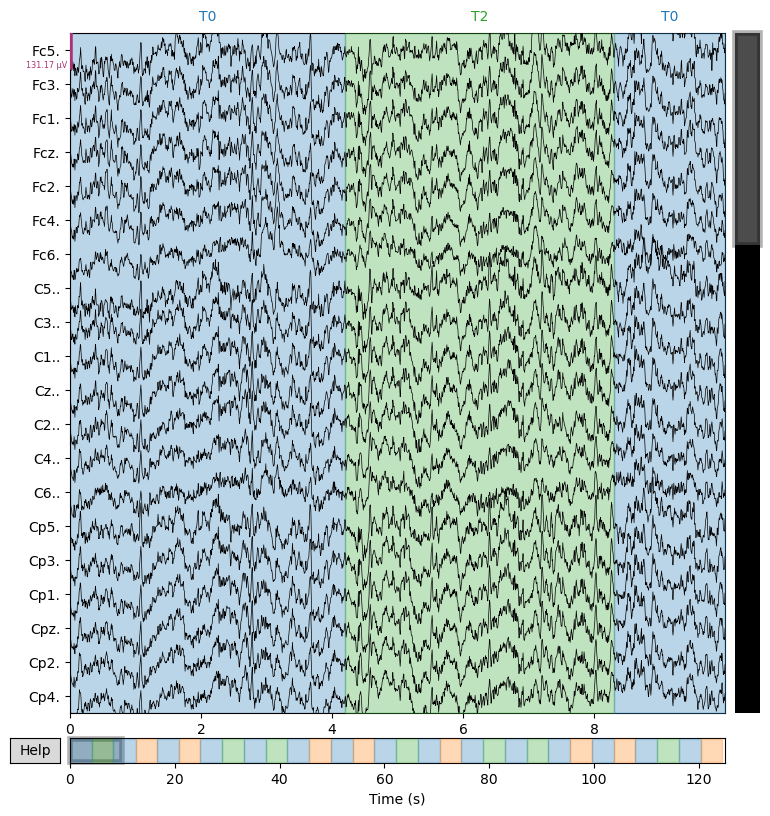

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


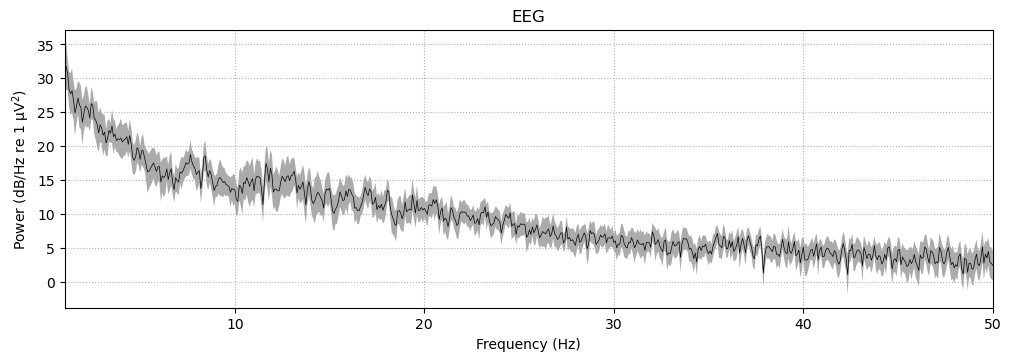

In [24]:
raw.plot(duration=10, n_channels=20, scalings='auto')
raw.plot_psd(fmin=1, fmax=50, average=True)
